# Project 7 - Create a model to predict the revenues of potential customers using ANOVA and Linear Regression.

🎯 Goal: Create a model to predict the future revenue of children based on their location, the revenue of their parents and the gini index; in order to target future customers.

## Part 4 - Modeling

Here are the hypothesis for the tests:
- H0 – There is no significant difference among the groups. What we observe is the random noise due to the sampling effect.
- H1 – There is a significant difference among the groups

If the p-value is below 0.05, we reject the null hypothesis in favor of the alternative: this means that at least one group mean is significantly different.

### Get started

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats  
import seaborn as sns
from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.tsa.api as smt
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import linear_harvey_collier
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn import preprocessing
import scipy.stats as st
import statsmodels.stats.stattools as tool
import random
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import pingouin as pg
from scipy.stats import chisquare

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
# Function to extract only the features to evaluate the performances of the model
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

In [86]:
# Identify the outliers for each features in both categories
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_out = df[~(((df < (Q1 - 1.3 * IQR)) |(df > (Q3 + 1.3 * IQR))).any(axis=1))] # We reduce a bit the threshold to remove more outliers
    
    return df_out

In [167]:
# Read the data with parent's class and child revenues
df = pd.read_csv(Path.cwd()/'Processed'/'final_dataset.csv',index_col=0)

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [168]:
# Read data with Gini index and Average income by country
inc_avg = pd.read_csv(Path.cwd()/'Processed'/'worldbank_avg.csv',index_col=0)

In [169]:
# Compile all together
df = pd.merge(df, inc_avg[['name','new_gini','income']], on = 'name', how = 'inner')
df.rename(columns= {'income_x':'income','income_y':'avg_income'},inplace=True)
df.head()

,name,c_i_parent,income,new_gini,avg_income
0,Albania,1,728.89795,32.141019,2994.829902
1,Albania,1,728.89795,32.141019,2994.829902
2,Albania,1,728.89795,32.141019,2994.829902
3,Albania,1,728.89795,32.141019,2994.829902
4,Albania,1,728.89795,32.141019,2994.829902


In [170]:
# Apply Log Transformation
df['log_income'] = np.log2(df['income'])
df.head()

,name,c_i_parent,income,new_gini,avg_income,log_income
0,Albania,1,728.89795,32.141019,2994.829902,9.509573
1,Albania,1,728.89795,32.141019,2994.829902,9.509573
2,Albania,1,728.89795,32.141019,2994.829902,9.509573
3,Albania,1,728.89795,32.141019,2994.829902,9.509573
4,Albania,1,728.89795,32.141019,2994.829902,9.509573


### ANOVA

In this notebook, ANOVA is applied to verify the effect of a qualitative variable (country's name) on a quantitative variable (income).

#### Country ~ Income 

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='income', ylabel='Density'>

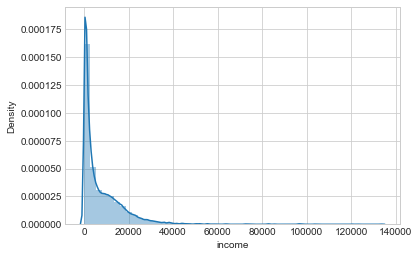

In [6]:
# Quick view on the distribution of income
sns.distplot(df.income)

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='income', ylabel='Density'>

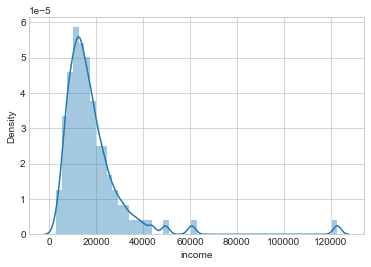

In [7]:
# Example with France
tmp = df[df.name == 'France']
sns.distplot(tmp.income)

<b> As expected, the distribution of income is skew to the right - meaning that there are some very high incomes. </b> Because of this profile, which is not really following a Gaussian-like distribution, we can expect the model, to not perform very well.

In [8]:
# ANOVA 1-way with income values
model = ols('income ~ C(name)',data = df).fit()
table = sm.stats.anova_lm(model,type=2)
anova_table(table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(name),1.167181e+14,50.0,2.334362e+12,42349.629417,0.0,0.466162,0.46615
Residual,1.336631e+14,2424895.0,5.512119e+07,NaN,NaN,NaN,NaN


<div class = 'alert alert-block alert-info'>
<b> If we check the “basics” parameters, here is what we can see:</b>

- Eta-squared is low, which might indicates that the model is not fitting well the data.
- The model sum of square is slightly lower than the error sum of square, which means that a big part of the total variability of the observed data still remains unexplained.
- The MSE is high in both cases - for the variable and for the residual, which indicates again that the model is not performing well to fit and predict the data.


- p-value << alpha risk (5%), meaning that at least one group is different than the rest (so that the income depend on the country). 
    
Let's try to improve the model by transforming the income with a log function. </div>

#### Country ~ Log_income

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


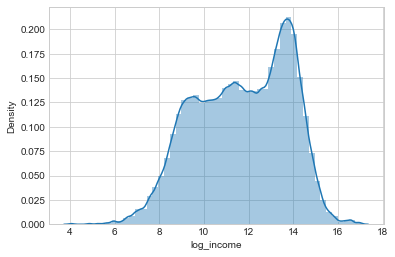

In [10]:
# Quick view on the distribution of log income
sns.distplot(df.log_income)
plt.savefig(Path.cwd()/'Plot'/'BoxPlot_LOGIncome_Countries.png')

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_income', ylabel='Density'>

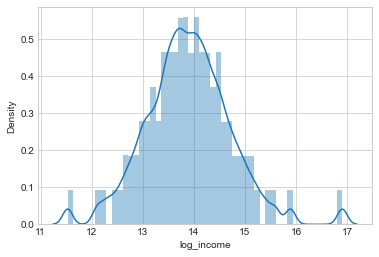

In [11]:
# Example with France
tmp = df[df.name == 'France']
sns.distplot(tmp.log_income)

<b> Transforming the income with a log function, help to normalize the data points and have a more Gaussian-like shape. </b> We can expect the model, to perform a bit better with this transformed variable.

In [12]:
# ANOVA 1-way with log-income values
model2 = ols('log_income ~ C(name)',data = df).fit()
table2 = sm.stats.anova_lm(model2,type=2)
anova_table(table2)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(name),7.975793e+06,50.0,159515.854445,151384.799938,0.0,0.757368,0.757363
Residual,2.555139e+06,2424895.0,1.053711,NaN,NaN,NaN,NaN


<div class= 'alert alert-block alert-info' >
<b> Using the log-income help to improve the model:</b>

- Eta-squared is now around 0.76 which is better than for the model with the income. It is still relatively low (we generally aim for at least 90%), probably because there are others important variables to explain the variability of incomes.
- The model sum of square is about 3 times higher than the error sum of square, which indicates that the country name is a pretty good parameter to explained and predict the income: 
    - Variability explained by the country equals = 7.975793e+06
    - Variability explained by other factors not included in the model = 2.555139e+06
- The MSE is high for the predictor (country name) but much lower than with the previous model. The MSE for the residual is around 1, which indicates again that the model is performing better than the previous model to fit and predict the data but could be improved.


<b> p-value << alpha risk (5%), meaning that at least one group is different than the rest (so that the income depend on the country). </b>
- The variability of income can be partly explained by the country we are observing, meaning that if we are observing the income from Angola or from Denmark, we can expect the income to be different. 
    </div>

### ANOVA Assumptions

There are certain assumptions we need to verify for the ANOVA:

- <b> NORMALITY - The assumption of normality is tested on the residuals of the model.</b>
    - Can be verified using histograms and Q-Q plot, or using statistical tests such as Shapiro-Wilk.
    - With violations of normality, continuing with ANOVA is generally ok if you have a large sample size.
    
    
- <b> HOMOGENEITY of variance: Homogeneity means that the variance among the groups should be approximately equal. </b>
    - Can be tested using tests such as Levene’s test or the Brown-Forsythe Test.
    - In general, with violations of homogeneity, the analysis is considered robust if you have equal-sized groups.

 
- <b> INDEPENDENCE - The sample cases should be independent of each other.The observations are obtained independently and randomly from the population defined by the factor levels. </b>
    - can be verified with ACF (autocorrelation function) plots and Durbin-Watson test.
    - ANOVA is not robust to violations to the assumption of independence.

##### 1. Normality

We start with the model based on income.

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

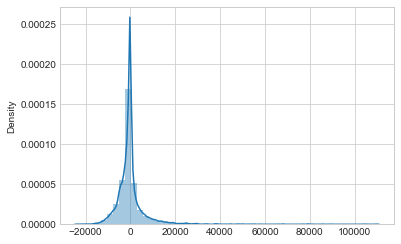

In [13]:
# Plot distribution to visualize the normality
sns.distplot(model.resid)

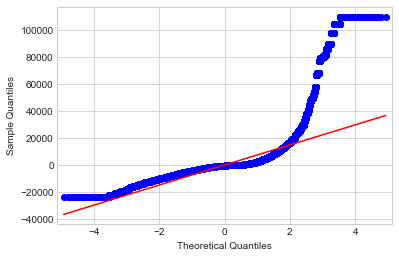

In [14]:
# Draw the Q-Q plot to visualize the adequation to the normality
qqplot(model.resid, line='s')
pyplot.show()

In [15]:
# Just check the kurtosis value
st.kurtosis(model.resid)

53.09520951601745

In [16]:
# Just check the kurtosis value
st.skew(model.resid)

5.356074098599249

In [203]:
# Run a Jarque-Bera test
st.jarque_bera(model.resid)

Jarque_beraResult(statistic=296434633.28979135, pvalue=0.0)

<b> The Jarque-Bera test verify whether the sample has the skewness and kurtosis matching with a normal distribution, i.e., skewness=0 and kurtosis =3. </b>
With:
- H0: The sample comes from a normal distribution.
- H1: The sample is not coming from normal distribution.

Here, with a pv-value << 5%, the null hypothesis is rejected --> the residuals are not following a Normal distribution.

<div class= 'alert alert-block alert-info' >
<b> The distribution of the residuals for the model based on income is clearly not following a Normal Distribution. </b> The distribution is leptokurtic meaning that the kurtosis value is largely above 3. Excess kurtosis means the distribution of event outcomes have lots of instances of outlier results. We can see these outliers and/or extreme values on the QQ-plot causing a fat right tail (so corresponding to very high incomes). In addition, the skew value is largely above zero (e.g. which is the target value for a Normal Distribution) meaning that we have we have high incomes causing a right fat tail. This is expected considering the data we are working with. </div>

Then we check for the model based on log-income.

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

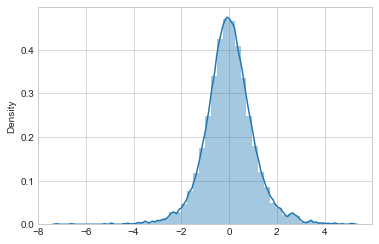

In [17]:
# Plot distribution to visualize the normality
sns.distplot(model2.resid)

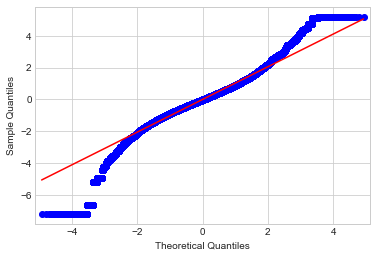

In [18]:
# Draw the Q-Q plot to visualize the adequation to the normality
qqplot(model2.resid, line='s')
pyplot.show()

In [19]:
# Just check the kurtosis value
st.kurtosis(model2.resid)

2.616544089626734

In [20]:
# Just check the kurtosis value
st.skew(model2.resid)

-0.011398371085222453

In [204]:
# Run a Jarque-Bera test
st.jarque_bera(model2.resid)

Jarque_beraResult(statistic=691798.9680325215, pvalue=0.0)

<b> Despite having coefficients very close to the reference values, the JB test indicates a non-normality of the residuals. </b> We can also notice (in addition of a p-value << 5%) that the test statistic is far from zero, indicating that the data do not have a normal distribution. 

<div class= 'alert alert-block alert-success' >
<b> The distribution is relatively close to a normal distribution but has some fat tails to the right and left and is slightly in S shape. </b> For normally distributed data, the kurtosis should be equal to 3, here we are just a bit below. The skew value is also very close to zero (e.g. Normal value) so very close to the Normal distribution. We can not conclude on the Normality based on these plots and metrics, but we can notice that transforming the income with a log function help to be closer to a Normal distribution. </div>

<b> Because we have a sample size > 5000, shapiro test is actually not ideal </b> (For N > 5000 the W test statistic is accurate but the p-value may not be). We can use the Anderson and Darling test or the non-parametric test Kolmogoriv and Smirnov.

<b> Anderson & Darling Hypothesis: </b>
- H0 = The sample is drawn from a population that follows a particular distribution, here the Normal distribution. 
- H1 = The sample is NOT drawn from a population that follows the Normal distribution.

If the returned statistic is larger than these critical values then for the corresponding significance level, the null hypothesis that the data come from the chosen distribution can be rejected. 

In [21]:
st.anderson(model2.resid,dist='norm')

AndersonResult(statistic=10248.77901675459, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

<b> Here the statistic value is largely above any of the critical values, meaning that we are in the zone where H0 can be rejected. The residuals are not following a Normal distribution. </b> The Anderson-Darling test is a modification of the Kolmogorov-Smirnov (K-S) test and gives more weight to the tails than does the K-S test. Here we have some fatty tails, so perhaps the test does not verify the Normality because of them. Let's try to apply the KS test.  

<b> Kolmogorov & Smirnov test: </b>
- H0 = The one-sample test performs a test of the distribution F(x) of an observed random variable against a given distribution G(x). Under the null hypothesis, the two distributions are identical, F(x)=G(x) with G(x) Normal Distribution.
- H1 = Under the alternative hypothesis, the two distributions are not identical.

In [22]:
st.kstest(model2.resid, 'norm')

KstestResult(statistic=0.0335421489967489, pvalue=0.0)

<b> Here the p-value is < 5% which means that we can not accept H0. Again the residuals are not following a Normal distribution. </b>

<div class= 'alert alert-block alert-info'> The QQ-plot and the statisticals tests are not showing that the residuals are following a Normal Distribution. We can see in the boxplot below that a lot of countries have outliers values. These data points might contribute to the non-normal distribution. Let's see if we can improve the model AND be in the conditions of applications by removing the outliers. </div>

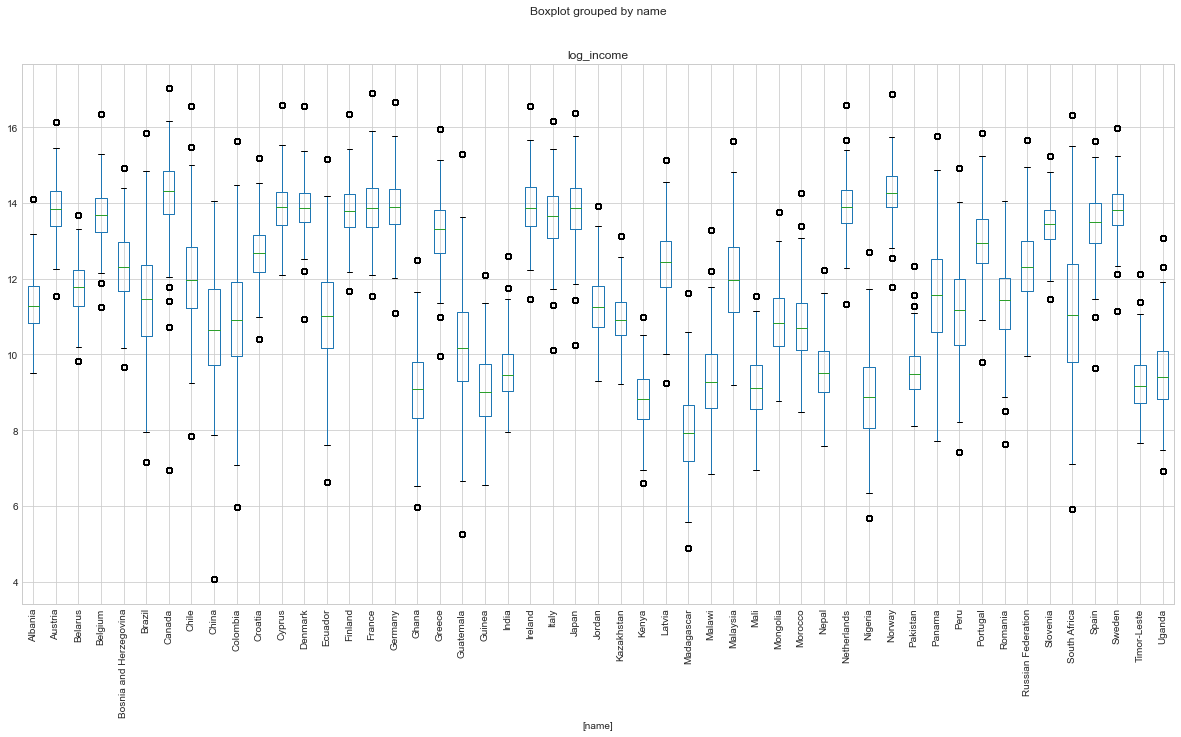

In [23]:
# Visualize the relationships between the 2 variables
tmp = df[['name','log_income']]
tmp.boxplot(by='name',figsize=(20,10))
plt.xticks(rotation=90)
plt.savefig(Path.cwd()/'Plot'/'BoxPlot_LOGIncome_Countries.png')
plt.show()

<b> We can see that depending on the country, the distribution of income can be really different. And also, that for some groups of countries, the distribution is very alike. </b> 

In [25]:
# Remove outliers at country level
tmp = df[['name','log_income']]
df_out = tmp.groupby('name').apply(remove_outliers).reset_index(drop=True)

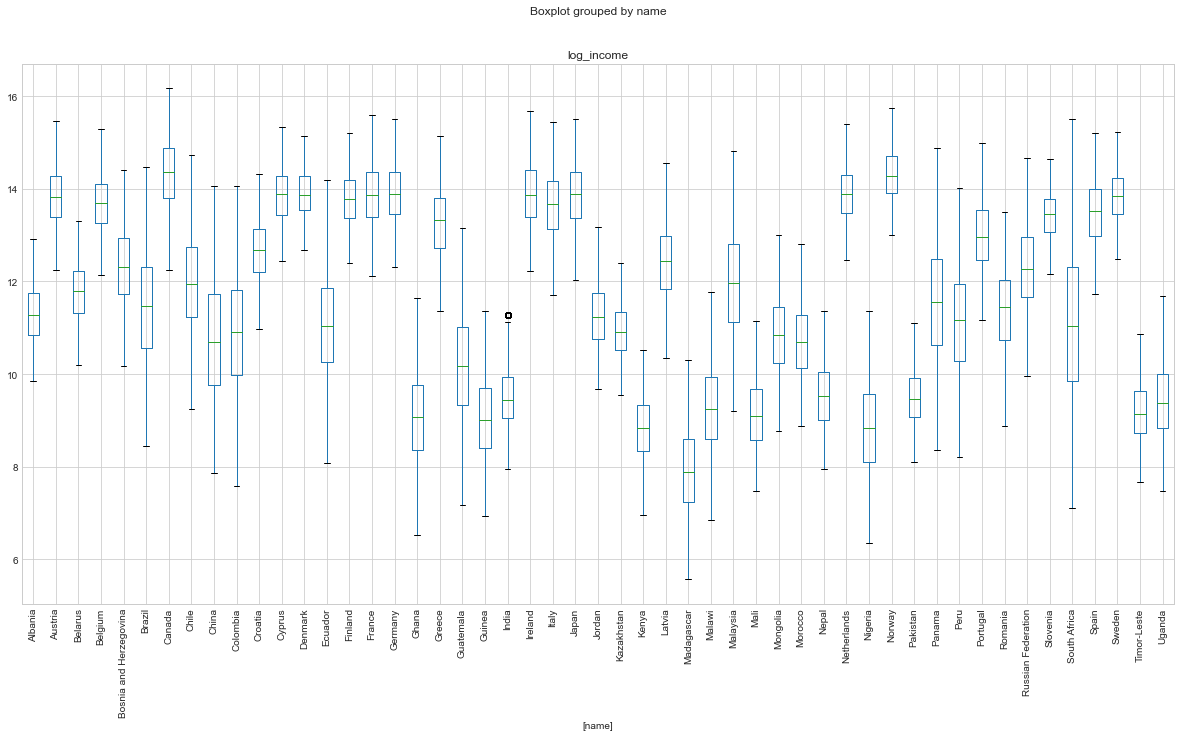

In [26]:
# Visualize the impact of the function
df_out.boxplot(by='name',figsize=(20,10))
plt.xticks(rotation=90)
plt.show()

In [27]:
# ANOVA 1-way with log-income values
model2bis = ols('log_income ~ C(name)',data = df_out).fit()
table2bis = sm.stats.anova_lm(model2bis,type=2)
anova_table(table2bis)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(name),7.892081e+06,50.0,157841.613194,194066.233412,0.0,0.804974,0.80497
Residual,1.912064e+06,2350882.0,0.813339,NaN,NaN,NaN,NaN


<b> Removing the outliers improve the model: the variance explained by the model is now about 80% vs 75% before removing the outliers. </b> Are we under the condition of Normality now?

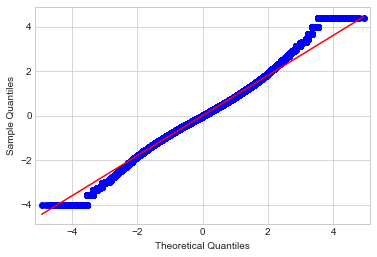

In [28]:
# Draw the Q-Q plot to visualize the adequation to the normality
qqplot(model2bis.resid, line='s')
pyplot.show()

<b> The QQ-plot is better after removing the outliers. </b> We still have left and right tails, which make sense as we will always have very low and very high incomes among our dataset.

In [29]:
# Can we see the Normality with the statistical test?
st.anderson(model2bis.resid,dist='norm')

AndersonResult(statistic=2595.519926542416, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

<b> The statistic value is still largely higher than the critical values BUT it decreases drastically (about 5 times) by removing the outliers. </b> 

In [30]:
st.kstest(model2bis.resid, 'norm')

KstestResult(statistic=0.04310841085363126, pvalue=0.0)

<b> The p-value is still below 0.05, we reject the null hypothesis in favor of the alternative. </b>

<div class= 'alert alert-block alert-info'>
    
Even after transforming with a log function AND removing the outliers, the residuals are not strictly following a Normal distribution but are very close to it. 
    
<b> The one-way ANOVA is considered a robust test against the normality assumption. </b> This means that it tolerates violations to its normality assumption rather well. As regards the normality of group data, the one-way ANOVA can tolerate data that is non-normal (skewed or kurtotic distributions) with only a small effect on the Type I error rate (when the null hypothesis is true, but is rejected). 
However, platykurtosis (when the peak of the curve of frequency distribution is comparatively flatter than that of normal distribution) can have a profound effect when your group sizes are small. This leaves you with two options: (1) transform your data using various algorithms so that the shape of your distributions become normally distributed or (2) choose the nonparametric Kruskal-Wallis H Test which does not require the assumption of normality.

    
- source: 
    - https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide-3.php
    - http://www.psicothema.com/pdf/4434.pdf
    
    
In a nutshell:     
- We are not in a situation with a platykurtosis distribution.
- The sample size is relatively big.
- We can assume that the non normality is causing by the tails. Considering the type of data we have, it is expected to have these tails (we want to keep the information about the low and high incomes). 
    
We might consider our model robust to the violation of this assumption. 
    </div>

##### 2. Homogeneity

The assumption of homogeneity of variance is an assumption of the independent samples t-test and ANOVA stating that all comparison groups have the same variance.  The independent samples t-test and ANOVA utilize the t and F statistics respectively, which are generally robust to violations of the assumption as long as group sizes are equal.  Equal group sizes may be defined by the ratio of the largest to smallest group being less than 1.5. 

- source: https://www.statisticssolutions.com/the-assumption-of-homogeneity-of-variance/


One method for testing this assumption is the Levene's test of homogeneity of variances. If the data is not following a normal distribution Levene’s test is preferred over the Barlett’s test. 

Hypothesis for the Levene test:
- H0: The variances are equal across all samples/groups
- H1: The variances are not equal across all samples/groups

If we look at the box-plot above, we can expect that the test will show a significant difference between the variance, in others words, that the homoscedasticity is not verified.

In [31]:
# Test homoscedasticity by comparing the group (= countries) with dependent variable = log_income
pg.homoscedasticity(df, dv='log_income', group='name',method='levene')

,W,pval,equal_var
levene,5713.564274,0.0,False


In [32]:
# Check the size of the 'groups'
tmp = df.groupby('name').count()[['log_income']].reset_index()
print('min:', tmp['log_income'].min(), 'max',tmp['log_income'].max(),'ratio',tmp['log_income'].max()/tmp['log_income'].min())

min: 47468 max 47636 ratio 1.003539226426224


<div class= 'alert alert-block alert-info'>
<b> As expected, the condition of homogeneity of variances is not respected. </b>

Numerous investigations have examined the effects of variance heterogeneity on the empirical probability of a Type I error for the analysis of variance (ANOVA) F-test and the prevailing conclusion has been that when sample sizes are equal, the ANOVA is robust to variance heterogeneity. However, we should not assumed that the ANOVA F-test is always robust to variance heterogeneity when sample sizes are equal.

- source: https://doi.org/10.2307/1162346 
American Educational Research Journal
Vol. 14, No. 4 (Autumn, 1977), pp. 493-498 (6 pages)
Published By: American Educational Research Association


In this case study, we do not have strictly the same size for each groups however the differences are very small (<< 1,5 between the largest and the smallest group), so we might consider our model robust to the violation of this assumption. 
    
<b> Alternatively, there are two tests that we could run that are applicable when the assumption of homogeneity of variances has been violated: (1) Welch or (2) Brown and Forsythe test. </b> </div>

##### 3. Independence

Independence of residual is commonly referred to as the total absence of autocorrelation. Even though uncorrelated data does not necessarily imply independence, one can check if random variables are independent if their mutual information tends to 0.

We can use a Durbin and Watson test which calculates the Durbin-Watson statistic. The test will output values between 0 and 4. Here are how to interpret the results of the test:
- The closer to 2, the more evidence for no autocorrelation.
- The closer to 0 the statistic, the more evidence for positive serial correlation. 
- The closer to 4, the more evidence for negative serial correlation.

<b> Here, we are using a dataset with duplicated rows, so we can expect this test to conclude of the non-independence of residuals. </b>

In [33]:
# Calculate Durbin and Watson statistic - model based on income
tool.durbin_watson(model.resid, axis=0)

0.0015256523669808562

In [34]:
# Calculate Durbin and Watson statistic - model based on log-income
tool.durbin_watson(model2.resid, axis=0)

0.0008159952809301728

In [35]:
# Calculate Durbin and Watson statistic - model based on income and without outliers
tool.durbin_watson(model2bis.resid, axis=0)

0.0004796685172174014

<b> The result suggest a positive autocorrelation in the residuals. </b> So the condition of independance is not verified.

<div class= 'alert alert-block alert-warning'>
All in all, none of the conditions necessary for applying an ANOVA are verified here. So, even tough the model retrieved some relatively good performances we can not rely on it. 
    
Let's try to build another model based on multiple linear regression.
    </div>

### Linear Model

In order for our machine learning to work well, it is very often necessary for the data to have the same scale in terms of the Feature to avoid bias in the outcome. We will test the effect of scaling the data on the performances of the models.

In [171]:
# Standardized both independent and dependent variables
df['gini_sc'] = preprocessing.scale(df['new_gini'])
df['avginc_sc'] = preprocessing.scale(df['avg_income'])
df['logavg_sc'] = preprocessing.scale(np.log2(df['avg_income']))
df['class_sc'] = preprocessing.scale(df['c_i_parent'])
df['inc_sc'] = preprocessing.scale(df['income'])
df['loginc_sc'] = preprocessing.scale(df['log_income'])

In [123]:
# Different modalities tested
X1 = df[['new_gini','avg_income']]
X2 = df[['gini_sc','avginc_sc']]
X3 = df[['new_gini','avg_income','c_i_parent']]
X4 = df[['gini_sc','avginc_sc','class_sc']]
X5 = df[['gini_sc','logavg_sc','class_sc']]

Y1 = df['income']
Y2 = df['inc_sc']
Y3 = df['log_income']
Y4 = df['loginc_sc']

#### Gini index & Average income (country) ~ Income

In [79]:
# With income and non-standardized data
x = sm.add_constant(X1) # let's add an intercept (beta_0) to our model
lin1 = sm.OLS(Y1, x).fit()
lin1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                 1.059e+06
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:15:53   Log-Likelihood:            -2.5053e+07
No. Observations:             2424946   AIC:                         5.011e+07
Df Residuals:                 2424943   BIC:                         5.011e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.2748     25.120     -0.727      0.467     -67.510      30.960
new_gini       0.5020      0.548      0.916      0.360      -0.572       1.577
avg_income     1.0001      0.001   1289.061      0.000       0.999       1.002
==============================================================================
Omnibus:                  2607390.809   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        296453827.484
Skew:                           5.356   Prob(JB):                         0.00
Kurtosis:                      56.097   Cond. No.                     5.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b> We retrieve a warning about a risk of multi-collinearity. After investigation, I found that standardizing the data might help. </b>

In [80]:
# with income and standardized data
lin1_sc = sm.OLS(Y2, X2).fit()
lin1_sc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 inc_sc   R-squared (uncentered):                   0.466
Model:                            OLS   Adj. R-squared (uncentered):              0.466
Method:                 Least Squares   F-statistic:                          1.059e+06
Date:                Fri, 02 Apr 2021   Prob (F-statistic):                        0.00
Time:                        13:16:02   Log-Likelihood:                     -2.6798e+06
No. Observations:             2424946   AIC:                                  5.360e+06
Df Residuals:                 2424944   BIC:                                  5.360e+06
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
gini_sc        0.0005      0.001      0.916      0.360      -0.001       0.002
avginc_sc      0.6830      0.001   1289.061      0.000       0.682       0.684
==============================================================================
Omnibus:                  2607390.809   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        296453827.484
Skew:                           5.356   Prob(JB):                         0.00
Kurtosis:                      56.097   Cond. No.                         1.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class = 'alert alert-block alert-info'>  

<b> R-squared is relatively low in this model. </b>
    - about 0.47 using the income, meaning that 47% of the variance of the income can be explained by the gini index and the average income vs 53% can be explained by other factors not included in the model. 
    
    
<b> It is standard practice to use the coefficient p-values to decide whether to include variables in the final model. </b> For the results above, we would consider removing Gini Index because its pvalue >> 5%. Keeping variables that are not statistically significant can reduce the model’s precision.

</div>

In [81]:
# with log income and non-standardized data
x = sm.add_constant(X1) 
lin2 = sm.OLS(Y3, x).fit()
lin2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_income   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                 2.227e+06
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:16:09   Log-Likelihood:            -3.9572e+06
No. Observations:             2424946   AIC:                         7.914e+06
Df Residuals:                 2424943   BIC:                         7.915e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8263      0.004   2347.127      0.000       9.818       9.834
new_gini       0.0002   9.14e-05      2.698      0.007    6.74e-05       0.000
avg_income     0.0002   1.29e-07   1870.105      0.000       0.000       0.000
==============================================================================
Omnibus:                    69625.341   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           169954.813
Skew:                          -0.104   Prob(JB):                         0.00
Kurtosis:                       4.280   Cond. No.                     5.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [88]:
# with log income and standardized data
x = sm.add_constant(X2) 
lin2_sc = sm.OLS(Y4, x).fit()
lin2_sc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              loginc_sc   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                 2.227e+06
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:32:09   Log-Likelihood:            -2.1767e+06
No. Observations:             2424946   AIC:                         4.353e+06
Df Residuals:                 2424943   BIC:                         4.353e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.784e-15      0.000   4.68e-12      1.000      -0.001       0.001
gini_sc        0.0012      0.000      2.698      0.007       0.000       0.002
avginc_sc      0.8052      0.000   1870.105      0.000       0.804       0.806
==============================================================================
Omnibus:                    69625.341   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           169954.813
Skew:                          -0.104   Prob(JB):                         0.00
Kurtosis:                       4.280   Cond. No.                         1.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class = 'alert alert-block alert-info'> 
    
<b> As expected, we get better results in terms of performances by using the log income than the income. </b>
R-squared is still relatively low but higher than with the income: about 0.65 using the log income, meaning that 65% of the variance of the log income can be explained by the gini index and the average income vs 35% can be explained by other factors not included in the model. In this model, we can also see that the gini index is relevant to explain the variance (its p-value < 5%).
    

<b> Standardizing the independent variables is a simple method to reduce multicollinearity that is produced by higher-order terms. </b> We can see that we drop the warning [2] when we use standardized data. 

#### Parent's class + Gini index + Average income (country) ~ Income

In [84]:
# Linear Regression with income as dependent variable on non-standardized data
x = sm.add_constant(X3) 
lin3 = sm.OLS(Y1, x).fit()
lin3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 8.049e+05
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:23:56   Log-Likelihood:            -2.4976e+07
No. Observations:             2424946   AIC:                         4.995e+07
Df Residuals:                 2424942   BIC:                         4.995e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3235.9899     25.642   -126.199      0.000   -3286.247   -3185.733
new_gini       0.5132      0.531      0.966      0.334      -0.528       1.554
avg_income     1.0002      0.001   1330.615      0.000       0.999       1.002
c_i_parent    63.7009      0.160    398.367      0.000      63.387      64.014
==============================================================================
Omnibus:                  2644289.626   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        326384380.363
Skew:                           5.459   Prob(JB):                         0.00
Kurtosis:                      58.777   Cond. No.                     5.79e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [85]:
# Linear Regression with income as dependent variable on standardized data
x = sm.add_constant(X4) 
lin3_sc = sm.OLS(Y2, x).fit()
lin3_sc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 inc_sc   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 8.049e+05
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:24:49   Log-Likelihood:            -2.6030e+06
No. Observations:             2424946   AIC:                         5.206e+06
Df Residuals:                 2424942   BIC:                         5.206e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.223e-16      0.000  -4.89e-13      1.000      -0.001       0.001
gini_sc        0.0005      0.001      0.966      0.334      -0.001       0.002
avginc_sc      0.6830      0.001   1330.615      0.000       0.682       0.684
class_sc       0.1811      0.000    398.367      0.000       0.180       0.182
==============================================================================
Omnibus:                  2644289.626   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        326384380.363
Skew:                           5.459   Prob(JB):                         0.00
Kurtosis:                      58.777   Cond. No.                         1.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class = 'alert alert-block alert-info'>  

<b> R-squared is still relatively low (about 50%) in this model but higher than without the parent's class (~47%). Adding the parent's classe improve the global performances of the model. </b> It means that, half of the variance of the income can be explained by the independent variables and half by other factors not included in the model. So this is not a very powerful model.
    
    
<b> It is standard practice to use the coefficient p-values to decide whether to include variables in the final model. </b> For the results above, we would consider removing Gini Index because its pvalue >> 5%. Keeping variables that are not statistically significant can reduce the model’s precision.
    
<b> Again, standardizing the independent variables has a positive effect on the risk of multicollinearity. </b> We can see that we drop the warning [2] when we use standardized data. 

</div>

In [86]:
# Linear Regression with log income as dependent variable on non standardized data
x = sm.add_constant(X3) 
lin4 = sm.OLS(Y3, x).fit()
lin4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_income   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                 1.889e+06
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:29:52   Log-Likelihood:            -3.7603e+06
No. Observations:             2424946   AIC:                         7.521e+06
Df Residuals:                 2424942   BIC:                         7.521e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9884      0.004   2210.108      0.000       8.980       8.996
new_gini       0.0002   8.42e-05      2.961      0.003    8.43e-05       0.000
avg_income     0.0002   1.19e-07   2028.404      0.000       0.000       0.000
c_i_parent     0.0166   2.54e-05    653.997      0.000       0.017       0.017
==============================================================================
Omnibus:                    57545.715   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           121372.071
Skew:                          -0.126   Prob(JB):                         0.00
Kurtosis:                       4.067   Cond. No.                     5.79e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
# Linear Regression with log income as dependent variable and standardized data
x = sm.add_constant(X4) 
lin4_sc = sm.OLS(Y4, x).fit()
lin4_sc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              loginc_sc   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                 1.889e+06
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:37:39   Log-Likelihood:            -1.9798e+06
No. Observations:             2424946   AIC:                         3.960e+06
Df Residuals:                 2424942   BIC:                         3.960e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.283e-15      0.000    6.5e-12      1.000      -0.001       0.001
gini_sc        0.0012      0.000      2.961      0.003       0.000       0.002
avginc_sc      0.8052      0.000   2028.404      0.000       0.804       0.806
class_sc       0.2299      0.000    653.997      0.000       0.229       0.231
==============================================================================
Omnibus:                    57545.715   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           121372.071
Skew:                          -0.126   Prob(JB):                         0.00
Kurtosis:                       4.067   Cond. No.                         1.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class = 'alert alert-block alert-info'>  

<b> R-squared is relatively good (about 70%) in this model. Adding the parent's class improve the global performances of the model AND using the log income AND using standardized data retrieved the best performances. </b>
70% of the variance of the income can be explained by the independent variables and 30% remains explained by other factors not included in the model. 
    
    
<b> The Gini index is relevant in this model. </b> Its pvalue is below 5%. 
The coefficient associated to the gini index is positive - varying between 0,5 and 0,0002.
For the record, the higher is the gini index the higher are the inequalities. 
So, in a linear regression problem, type y = ax+b where:
- y = log_income
- x = gini index

if a > 0, it means that when gini index increases the child income increases even more rapidly. 
So, the models suggest that the more unequalitarian is the country, the more (some groups of) people benefit from the situation.

</div>

Last test, with the log of average income and all variable standardized:

In [41]:
# Linear Regression with log income as dependent variable and standardized data and log of average of income
x = sm.add_constant(X5) 
lin5_sc = sm.OLS(Y4, x).fit()
lin5_sc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              loginc_sc   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                 3.441e+06
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:39:53   Log-Likelihood:            -1.4288e+06
No. Observations:             2424946   AIC:                         2.858e+06
Df Residuals:                 2424942   BIC:                         2.858e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.283e-15      0.000   8.15e-12      1.000      -0.001       0.001
gini_sc       -0.1151      0.000   -390.334      0.000      -0.116      -0.114
logavg_sc      0.8273      0.000   2806.483      0.000       0.827       0.828
class_sc       0.2299      0.000    820.870      0.000       0.229       0.230
==============================================================================
Omnibus:                   149497.328   Durbin-Watson:                   0.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           670696.288
Skew:                          -0.087   Prob(JB):                         0.00
Kurtosis:                       5.571   Cond. No.                         1.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class= 'alert alert-block alert-success'> The last linear model, based on the gini index, the log-average income and the parent's class, is the one providing the best performances to predict the income (log transformed): it explains 81% of the variances, meaning that only 19% remains unexplained and due to others factors ike fx. chance, efforts,...
    
In this last model, we can also notice that the coefficient associated to the gini index is negative.
    
<b> Let's check now if all the assumptions necessary for the linear model are verified. </b> </div>

### Linear Model Assumptions

There are five assumptions which support using a linear regression model for the purpose of inference or prediction:
- <b> LINEARITY </b> : The relationship between the dependent variables and the independent variable is linear.
- <b> NORMALITY </b> : The residuals must follow a Normal distribution.
- <b> HOMOSCEDASTICITY </b> : The residuals have constant variance no matter the level of the dependent variable.
- <b> INDEPENDANCE </b> : Residuals must be totally free of autocorrelation.
- <b> ABSENCE OF MULTICOLLINEARITY </b> : Multicollinearity refers to when two predictors (or more) are providing the same information about the response variable.

#### 1. Linearity

Pearson correlation coefficient is used to measure the strength and direction of the linear relationship between two variables. 

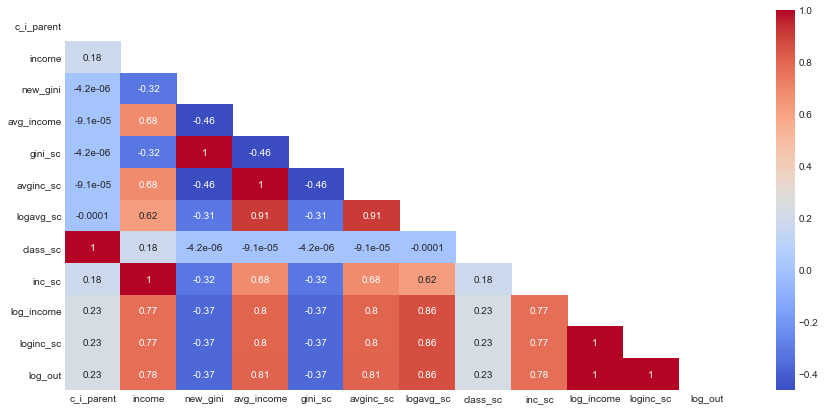

In [131]:
# correlation coefficients: By default, Pearson correlation coefficient is calculated
plt.subplots(figsize=(15,7))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), mask=mask,annot = True, cmap='coolwarm')
plt.show()

<b> The linear relationship between the log-income and: </b> 
- the  average income is very strong
- the parent's class and the gini index is weak.

The Pearson correlation coefficient measures the linear relationship between two datasets. Strictly speaking, Pearson’s correlation requires that each dataset be normally distributed. In case of non normality, we can use the Spearman coefficient:

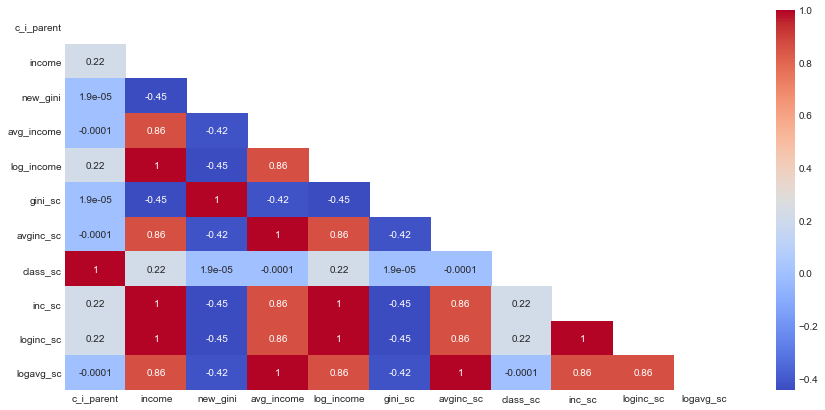

In [45]:
# correlation coefficients: based on Spearman coefficient
plt.subplots(figsize=(15,7))
corr = df.corr(method = 'spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask,annot = True, cmap='coolwarm')
plt.show()

The results are pretty similar with Spearman than with Pearson. 
Let's visualize these results.

In [134]:
# Create samples from population set
samp_inc = df.sample(100)
samp2 = df.dropna().sample(100)
samp_inc.head()

,name,c_i_parent,income,new_gini,avg_income,gini_sc,avginc_sc,logavg_sc,class_sc,inc_sc,log_income,loginc_sc,log_out
985438,Guinea,97,795.18020,41.217855,696.012013,0.245358,-1.020107,-1.515635,1.609735,-0.687087,9.635138,-0.998447,-0.998447
1661192,Morocco,81,5275.63230,42.296382,2337.600601,0.355186,-0.783538,-0.516398,1.055821,-0.246154,12.365128,0.311576,0.311576
2347801,Timor-Leste,64,500.28290,33.641588,727.610395,-0.526140,-1.015554,-1.479015,0.467287,-0.716108,8.966600,-1.319253,-1.319253
643497,Ecuador,59,2257.66240,52.463328,3383.741001,1.390496,-0.632778,-0.211346,0.294188,-0.543160,11.140614,-0.276024,-0.276024
1534897,Mali,81,393.90164,34.678231,681.075039,-0.420578,-1.022260,-1.533528,1.055821,-0.726577,8.621692,-1.484762,-1.484762


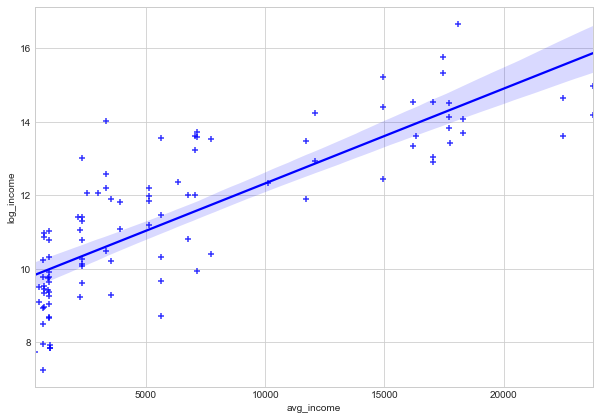

In [54]:
# regression plot using seaborn for average income and log of income
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=samp_inc.avg_income, y=samp_inc.log_income, color='blue', marker='+')
plt.savefig(Path.cwd()/'Plot'/'M4_Linearity_avgincome.png')
plt.show()

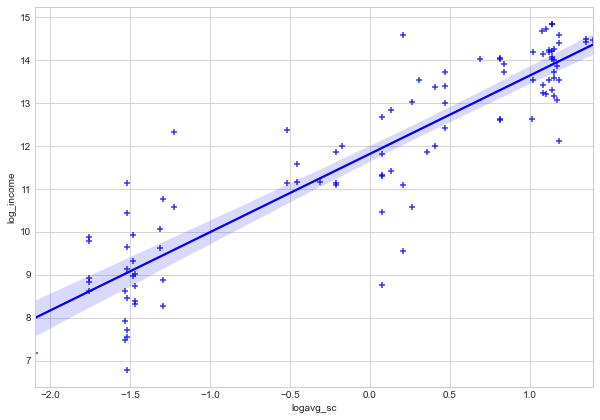

In [137]:
# regression plot using seaborn for log_average income and log of income
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=samp_inc.logavg_sc, y=samp_inc.log_income, color='blue', marker='+')
plt.savefig(Path.cwd()/'Plot'/'M4_Linearity_logavgincome.png')
plt.show()

<b> We can see on this sample, that the relationship between the log income and the average income (transformed or not with log) looks linear. </b>

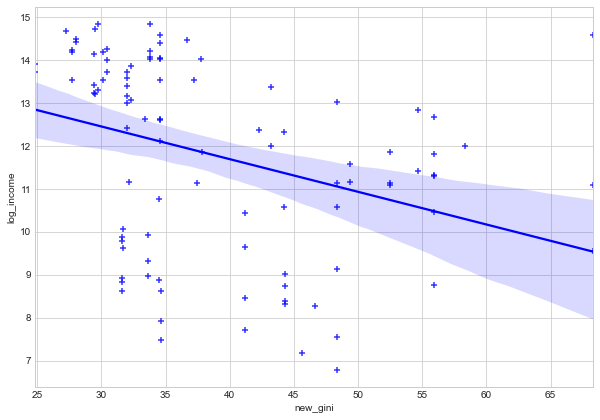

In [139]:
# regression plot using seaborn for gini index and log income
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=samp_inc.new_gini, y=samp_inc.log_income, color='blue', marker='+')
plt.savefig(Path.cwd()/'Plot'/'M4_Linearity_gini.png')
plt.show()

<b> We can see on this sample that the relationship between the log income and the gini index is not clearly linear. All in all, it looks like the 2 variables are negatively correlated (which is what we saw also with the Pearson and Spearman's values). </b> Removing the outliers does not change a lot the observations.

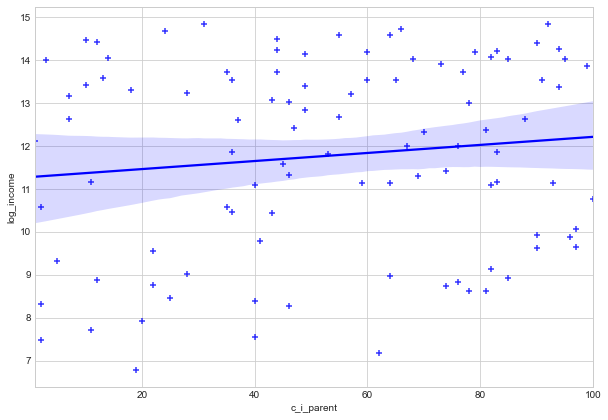

In [141]:
# regression plot using seaborn for parent's class and log of income
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=samp_inc.c_i_parent, y=samp_inc.log_income, color='blue', marker='+')
plt.savefig(Path.cwd()/'Plot'/'M4_Linearity_class.png')
plt.show()

<b> We can see on this sample that the relationship between the log income and the class is not linear. </b>

<div class = 'alert alert-block alert-info ' > 
<b> The scatter plot confirm what we have seen in the Pearson's and Spearman's correlation factors. </b> The linear relationship between the log_income and the gini index and the class is not verified. It is verified with the average_income. </div>

#### 2. Normality 

In the following steps, we are testing the conditions only for the last model, showing the best performances.

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


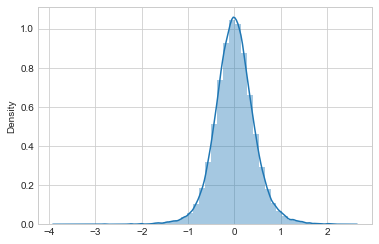

In [67]:
# Plot distribution to visualize the normality of residuals
sns.distplot(lin5_sc.resid)
plt.show()

In [72]:
# Just check the kurtosis value
st.kurtosis(lin5_sc.resid)

2.570580770964189

<b> The distribution is relatively close to a normal distribution. </b> The kurtosis value is also close to the Normal value (2.6 vs 3 for Normal distribution). Removing the outliers on log of income reduce the kurtosis (which is not what we were hoping for).

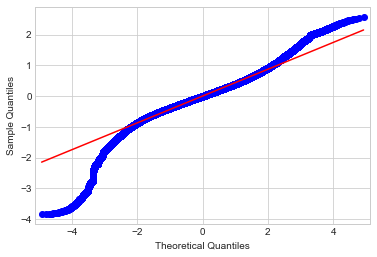

In [68]:
# Draw the Q-Q plot to visualize the adequation to the normality
qqplot(lin5_sc.resid, line='s')
pyplot.show()

In [71]:
# Just check the skewness value 
st.skew(lin5_sc.resid)

-0.08671972577373797

<b> The distribution of residuals is close to a normal distribution (following the straight line) but with a heavy left tail. </b> The skew value is however not that high and still close to zero (like for a Normal distribution).

<b> Kolmogorov & Smirnov test: </b>
- H0 = The one-sample test performs a test of the distribution F(x) of an observed random variable against a given distribution G(x). Under the null hypothesis, the two distributions are identical, F(x)=G(x) with G(x) Normal Distribution.
- H1 = Under the alternative hypothesis, the two distributions are not identical.

In [93]:
st.kstest(lin5_sc.resid, 'norm')

KstestResult(statistic=0.20826559732877087, pvalue=0.0)

<b> Here the p-value is < 5% which means that we can not accept H0. Again the residuals are not following a Normal distribution. </b>

<div class= 'alert alert-block alert-info'>
The condition of normality of the residuals is not verified however the distribution, skewness and kurtosis are very close to the Normal characteristic.
And, given the sample size of the data (N > 30 for each group) and according to the Central Limit Theorem, we are "protected" from violating this assumption and our findings will still be valid.
    
- source: http://www2.psychology.uiowa.edu/faculty/mordkoff/GradStats/part%201/I.07%20normal.pdf
    </div>

#### 3. Homogeneity

Hypothesis for the test:
- H0 : The error variances are all equal.
- H1: The error variances are not equal. More specifically, as Y increases, the variances increase (or decrease).

In [73]:
# Test to verify the homoscedasticity of residuals
test = het_breuschpagan(lin5_sc.resid, lin5_sc.model.exog)
name = ['statistic', 'p-value',
        'f-value', 'f p-value']
lzip(name, test)

[('statistic', 136746.85567300697),
 ('p-value', 0.0),
 ('f-value', 48306.28407956225),
 ('f p-value', 0.0)]

<div class= 'alert alert-block alert-info'>
<b> The condition of homogeneity of variances is not respected. </b> The test is significant meaning the data violates the assumption of homoscedasticity, i.e. heteroscedasticity is present in the data. 
 </div>

#### 4. Independence

Independence of residual is commonly referred to as the total absence of autocorrelation. Even though uncorrelated data does not necessarily imply independence, one can check if random variables are independent if their mutual information tends to 0.

We can use a Durbin and Watson test which calculates the Durbin-Watson statistic. The test will output values between 0 and 4. Here are how to interpret the results of the test:
- The closer to 2, the more evidence for no autocorrelation.
- The closer to 0 the statistic, the more evidence for positive serial correlation. 
- The closer to 4, the more evidence for negative serial correlation.

In [74]:
# Calculate Durbin and Watson statistic
tool.durbin_watson(lin5_sc.resid, axis=0)

0.007521762494598257

<b> The result suggest a positive autocorrelation in the residuals. </b> So the condition of independance is not verified.
<b> Here, we are using a dataset with duplicated rows, so we could expect this test to conclude of the non-independence of residuals. </b>

#### 2. Multicollinearity

We can check the existence of collinearity between two or more variables with the Variance Inflation Factor (VIF). It's a measure of colinearity among predictor variables within a multiple regression.

A rule of thumb for interpreting the variance inflation factor:

- 1 = not correlated.
- Between 1 and 5 = moderately correlated.
- Greater than 5 = highly correlated.

The more VIF increases, the less reliable your regression results are going to be. In general, a VIF above 10 indicates high correlation and is cause for concern. Some authors suggest a more conservative level of 2.5 or above. 

- source: https://www.statisticshowto.com/variance-inflation-factor/

In [76]:
# For each X, calculate VIF and save in dataframe
x5 = add_constant(X5)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x5.values, i) for i in range(x5.shape[1])]
vif["features"] = x5.columns
vif.round(1) #inspect results

,VIF Factor,features
0,1.0,const
1,1.1,gini_sc
2,1.1,logavg_sc
3,1.0,class_sc


<b> There is no collinearity between the features of the model. </b> 